In [60]:
import os
import numpy as np
import numpy.ma as ma
import xarray, dask
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap as bm
import pandas as pd
from scipy.interpolate import interp1d

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture

import seaborn as sns
import seawater as sw

In [61]:
# Number of GMM classes to compute:
K = 8

# Compression level for the dimensionality reduction 
maxvar = 99.9 # in %

In [62]:
# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

In [63]:
os.chdir('C:\\Users\\ramya\\Desktop\\myftpserver\\New Folder')

In [64]:
l=os.listdir()
leng=len(l)
latf=[]
longf=[]
#concatenating latitude and longitude values
for i in range(1,leng-14):  
    dset=xarray.open_mfdataset(l[i])
    latf= np.append(latf,dset['LATITUDE'].values)
    longf=np.append(longf,dset['LONGITUDE'].values)

In [65]:
#standard model depth
DPTmodel=np.linspace(0,2000,401)
size=[len(longf),DPTmodel.shape[0]]
X=np.ndarray(size,'float32')
sal_f=np.ndarray(size,'float32')
j=0
for i in range(1,leng-14):  
    dset=xarray.open_mfdataset(l[i])
    temp = dset['TEMP_ADJUSTED'].values 
    p=dset['PRES_ADJUSTED'].values
    lon = dset['LONGITUDE'].values
    lat = dset['LATITUDE'].values
    s=dset['PSAL_ADJUSTED'].values
    [a,b]=p.shape
    g=p.shape
    dp=np.ndarray(g,'float32')
    svelocity=np.ndarray(g,'float32')
    #calculating depth and sound velocity
    for ii in range(a):
        dp[ii]=np.asarray((sw.dpth(p[ii],lat[ii])))
        #svelocity[i]=np.asarray((sw.svel(s[i],temp[i],p[i])))
    sh=[a,DPTmodel.shape[0]]
    saline=np.ndarray(sh,'float32')
    #interpolation
    for i3 in range(a):
        saline[i3]=np.interp(DPTmodel,dp[i3],s[i3])

    for i4 in range(a):
        sal_f[j]=saline[i4]
        j+=1

#filling the mssing or nan values
df=pd.DataFrame(sal_f)
df=df.ffill(axis=0).values
sal_f=df
df=pd.DataFrame(sal_f)
df=df.bfill(axis=0).values
sal_f=df

sal_f=sal_f[~np.isnan(sal_f).any(axis=1)]
[Np, Nz] = sal_f.shape
print("Number of raw features (Depth Levels): ", Nz )
print("Number of samples (N profiles): ", Np)

Number of raw features (Depth Levels):  401
Number of samples (N profiles):  4768


In [66]:
#testing for missing values
for i in range(sal_f.shape[0]):
    p1=np.isnan(sal_f[i])
    for j in range(sal_f.shape[1]):
        if(p1[j]==True):
            print(i)
            break

In [67]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(sal_f)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_

# Normalize data:
Xn = scaler.transform(sal_f)        
# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(sal_f).transform(sal_f)

# Compute additional statistics, like the observed PDFz:
def diag_pdfz(sal_f,xedges):
    Nz = sal_f.shape[1]
    PDFz = np.zeros((xedges.shape[0]-1,Nz))
    for iz in np.arange(Nz):
        h, hx = np.histogram(sal_f[:,iz],bins=xedges,density=True)
        PDFz[:,iz] = h
    PDFz_axis = hx[0:-1]
    return PDFz, PDFz_axis
PDFz, PDFz_axis = diag_pdfz(sal_f,np.arange(np.min(sal_f),np.max(sal_f),0.2))

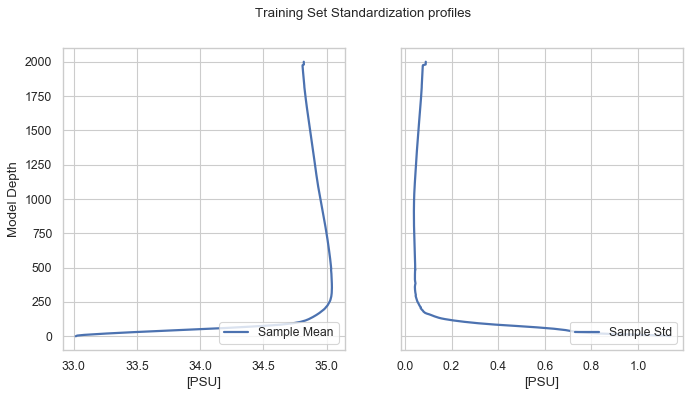

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X_ave, DPTmodel, '-', linewidth=2,label='Sample Mean')
ax[1].plot(X_std, DPTmodel, '-', linewidth=2,label='Sample Std')
# tidy up the figure
ax[0].set_ylabel('Model Depth')
for ix in range(0,2):
    ax[ix].legend(loc='lower right')
    ax[ix].grid(True)
    ax[ix].set_xlabel('[PSU]')
fig.suptitle('Training Set Standardization profiles', fontsize=12)
plt.show()

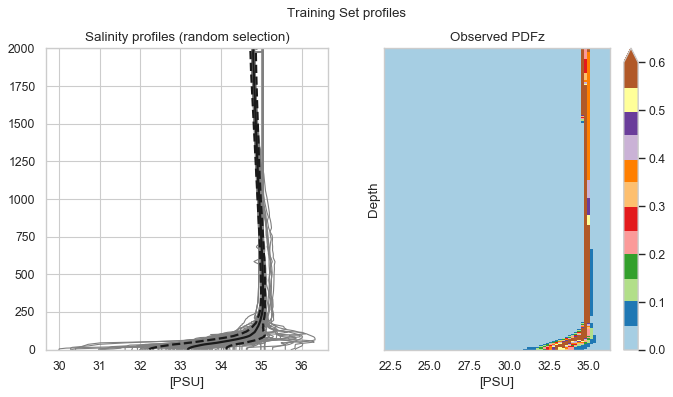

In [83]:
# Select 150 random profiles:
n = 150
ip = np.unique(np.random.randint(0,Np-1,n))

# Random selection of profiles
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(sal_f[ip,:].T, np.reshape(np.repeat(DPTmodel,ip.shape[0]),[Nz,ip.shape[0]]), '-', color='gray', linewidth=1)
ax[0].plot(np.mean(sal_f[ip,:].T,axis=1), DPTmodel, '-', color='k', linewidth=2)
ax[0].plot(np.mean(sal_f[ip,:].T,axis=1)-np.std(sal_f[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].plot(np.mean(sal_f[ip,:].T,axis=1)+np.std(sal_f[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].grid(True)
ax[0].set_title('Salinity profiles (random selection)')
ax[0].set_xlabel('[PSU]')

cmap = plt.get_cmap('Paired',lut=128)
df = xarray.DataArray(PDFz.T, coords=[DPTmodel,PDFz_axis], dims=['Depth','[PSU]'])
p = df.plot(cmap=cmap,vmin=0,vmax=0.6,ax=ax[1])
ax[1].set_title("Observed PDFz")

fig.suptitle('Training Set profiles', fontsize=12)
plt.show()

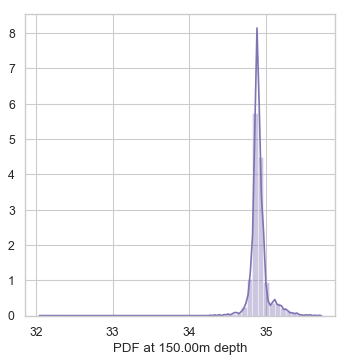

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook",style="whitegrid", palette="deep", color_codes=True)
iz = 30
sns.distplot(sal_f[:,iz], norm_hist=True, color="m", axlabel="PDF at %0.2fm depth"%(DPTmodel[iz]))
plt.show()

C:\Users\ramya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


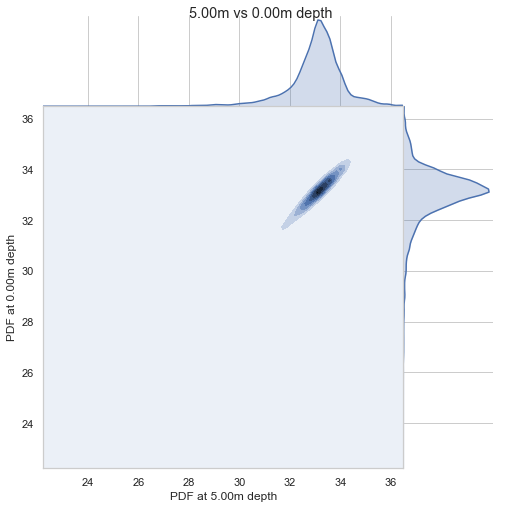

In [71]:
iz1 = 1
iz2 = np.argmax(DPTmodel<=-300)
x = sal_f[:,iz1]
y = sal_f[:,iz2]
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook",style="whitegrid", color_codes=True)
sns.jointplot(x=x, y=y, kind="kde",\
              xlim=vrange([x,y]),ylim=vrange([x,y]),\
              size=7, ratio=4, space=0)\
            .set_axis_labels("PDF at %0.2fm depth"%(DPTmodel[iz1]), "PDF at %0.2fm depth"%(DPTmodel[iz2]))
plt.suptitle("%0.2fm vs %0.2fm depth"%(DPTmodel[iz1],DPTmodel[iz2]))
plt.show()

In [72]:
# Compute P (the EOFs) from x:
reducer = PCA(n_components=maxvar/100,svd_solver='full')
reducer.fit(Xn)

# Reduce the dataset (compute the y):
Xr = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

# Variables of the reduced space:
Nc = reducer.n_components_ # Number of components retained
EOFs = reducer.components_ # [Nc , Nz], the P matrix
V = reducer.explained_variance_ratio_ # Explained variance, with 0 to 1 values

# We can also compute EOFs with real units this way:
S = np.sqrt(reducer.explained_variance_*Xn.shape[0]) # These are the singular values
Z = np.dot(Xn - reducer.mean_, np.transpose(reducer.components_)) # This is simply Xr or the principal components
Ztilde = Z/np.sqrt(S) # Normalized PCs
#EOFs_real = np.dot(np.transpose(Ztilde),X)/X.shape[0] # Regression on any collection of profiles
EOFs_realc = np.dot(np.transpose(Ztilde),Xc)/Xc.shape[0] # Regression on any collection of profiles
EOFs_real = np.dot(np.transpose(Ztilde),Xn)/Xn.shape[0] # Regression on any collection of profiles

# Compute the RMS difference between the reconstructed and original dataset:
Xn_reconstructed = reducer.inverse_transform(Xr)
X_reconstructed = scaler.inverse_transform(Xn_reconstructed)
rms = np.sqrt(np.mean(np.square(X_reconstructed-sal_f),axis=0))

#
print ("\nWe reduced the dimensionality of the problem from %i depth levels down to %i PCs\n"%(Nz,Nc))


We reduced the dimensionality of the problem from 401 depth levels down to 53 PCs



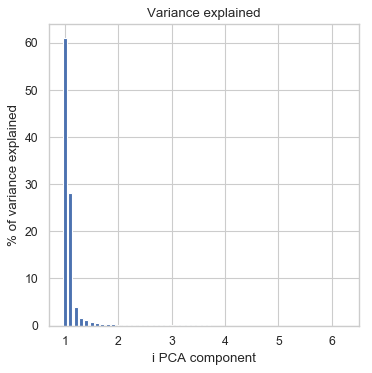

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax.bar(range(0,Nc),V*100)
ax.set_xlabel('i PCA component')
ax.set_ylabel('% of variance explained')
ax.grid(True)
ax.set_xticklabels(range(0,Nc))
ax.set_title('Variance explained')
plt.show()

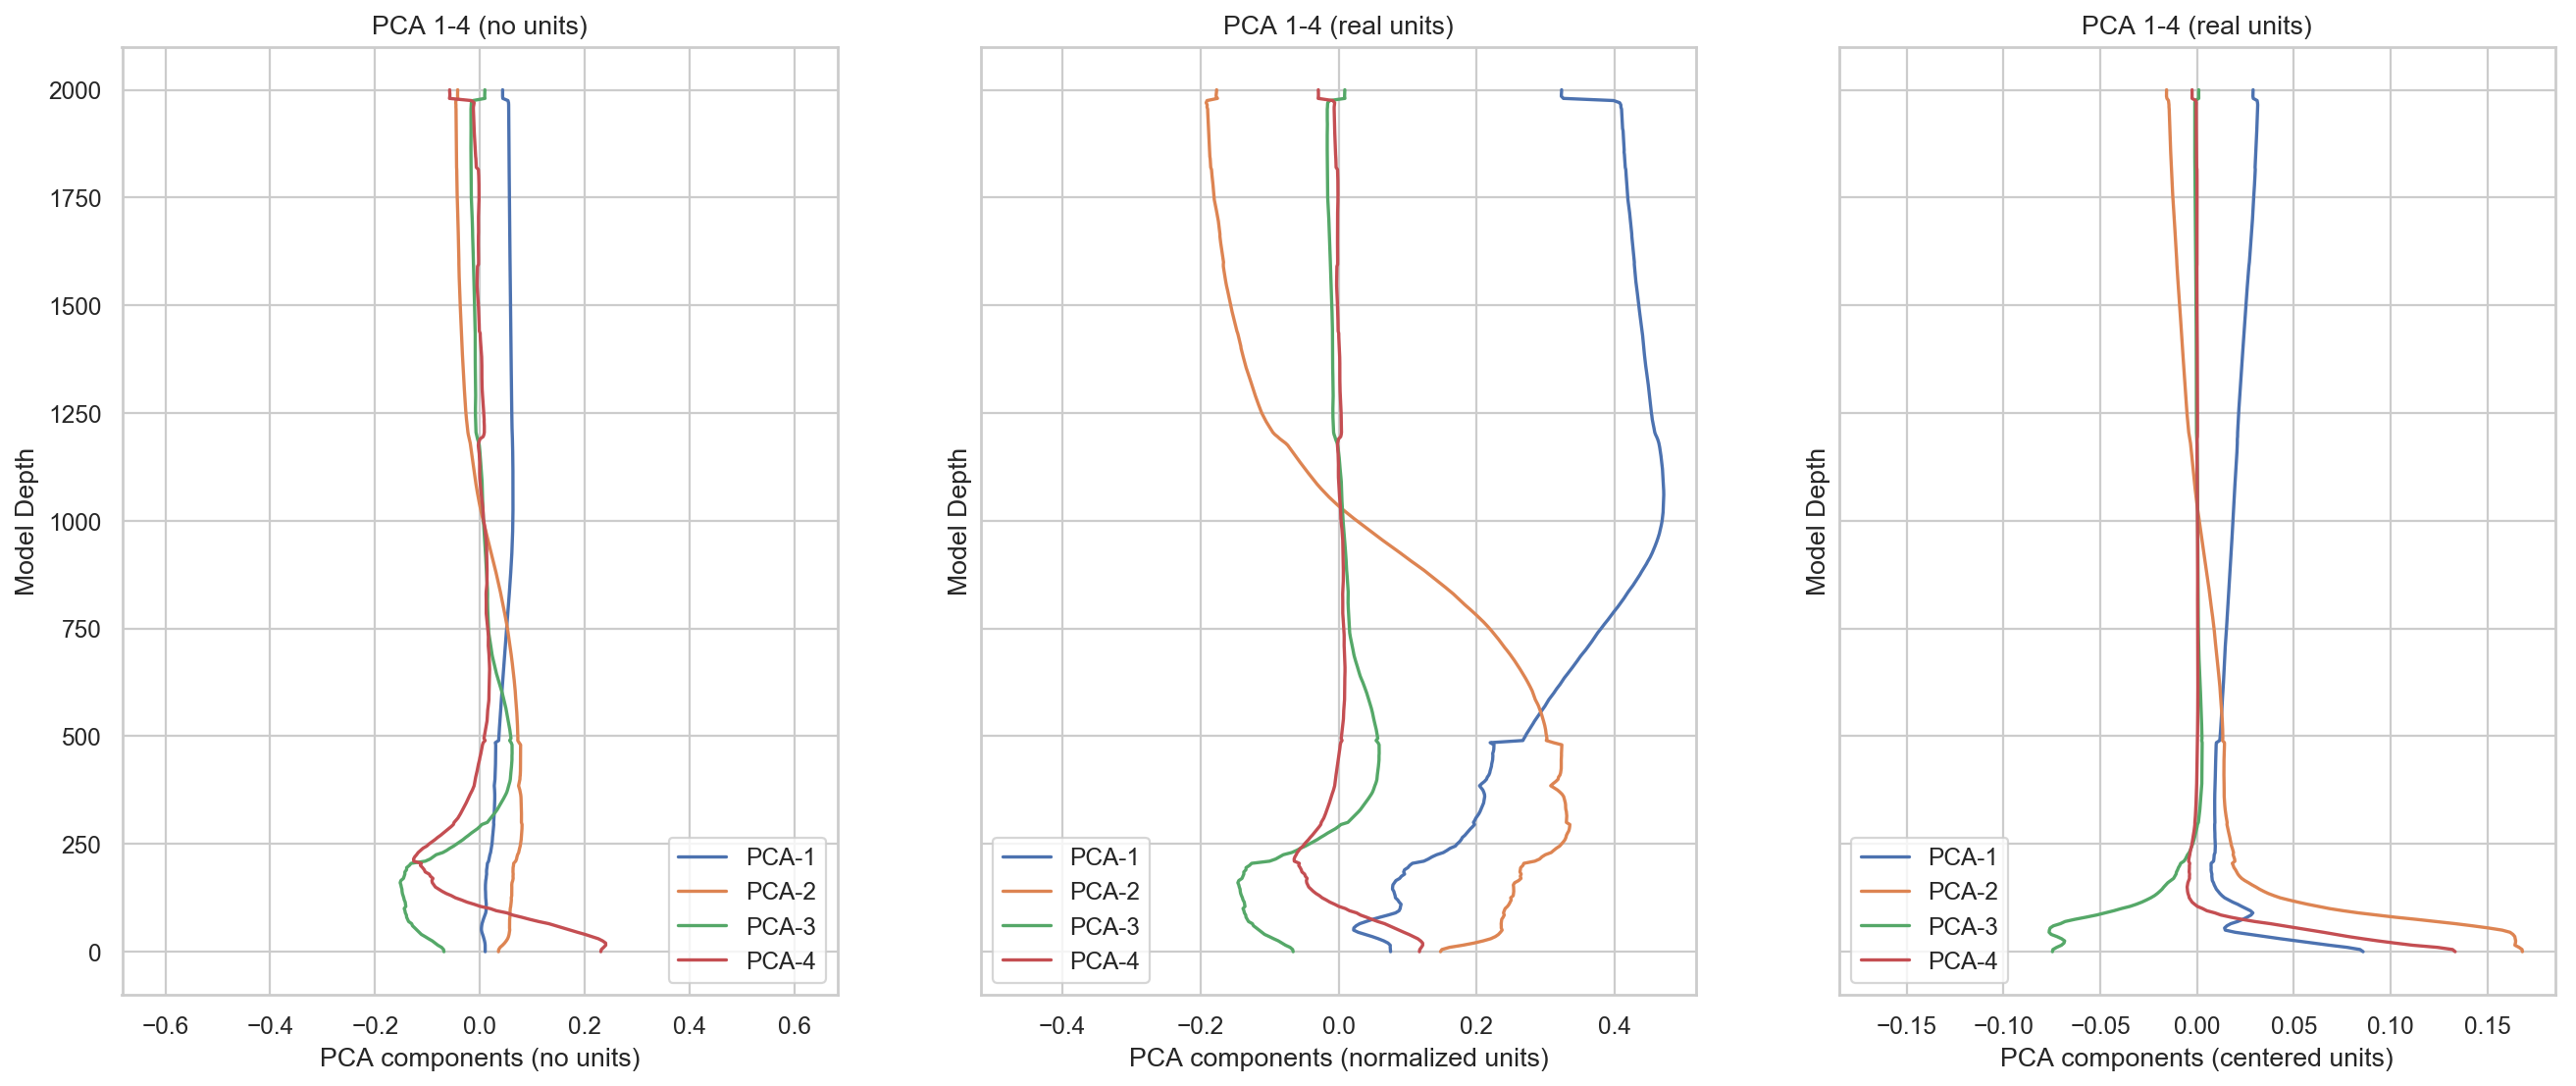

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8), dpi=160, facecolor='w', edgecolor='k', sharey='row')

iax = 0
xl = np.max(np.abs([np.min(EOFs),np.max(EOFs)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower right')
ax[iax].set_xlabel('PCA components (no units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (no units)')

iax+=1
xl = np.max(np.abs([np.min(EOFs_real),np.max(EOFs_real)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs_real[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower left')
ax[iax].set_xlabel('PCA components (normalized units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (real units)')

iax+=1
xl = np.max(np.abs([np.min(EOFs_realc),np.max(EOFs_realc)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs_realc[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower left')
ax[iax].set_xlabel('PCA components (centered units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (real units)')
plt.show()

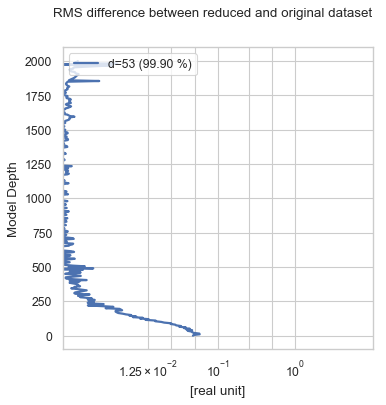

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax.semilogx(rms, DPTmodel, '-', linewidth=2,label="d=%i (%0.2f %%)"%(Nc,np.sum(V*100)))
# tidy up the figure
ax.legend(loc='upper left')
ax.set_xticks([0.0125,0.025,0.05,0.1,0.25,0.5,1])
ax.set_xlim([1e-3,1e1])
ax.set_xlabel('[real unit]')
ax.set_ylabel('Model Depth')
ax.grid(True)
fig.suptitle('RMS difference between reduced and original dataset', fontsize=12)
plt.show()

In [76]:
# Set-up and train the classifier:
gmm = GaussianMixture(n_components=K,\
                      covariance_type='full',\
                      init_params='kmeans',\
                      max_iter=1000,\
                      tol=1e-6)
gmm.fit(Xr) # Training on reduced data

# Extract GMM parameters:
priors = gmm.weights_ # [K,1]
centers= gmm.means_   # [K,Nc]
covars = gmm.covariances_ # [K,Nc,Nc] if 'full'

# Classify the dataset:
LABELS = gmm.predict(Xr) # [Np,1]
POST   = gmm.predict_proba(Xr) # [Np,Nc]

In [77]:
def plot_GMMellipse0(gmm,id,ik,col,ax,label=""):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 dimensions (id) 
        of the GMM model gmm
        This is the class routine, using the matplotlib Ellipse method
        I don't like it because the Ellipse object cannot be labelled...
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi 
    v = 2. * np.sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[ik,(id[0],id[1])], v[0], v[1],180 + angle,\
                                         fill=False,label=label)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(1)
    ell.set_label("Class #%i"%(ik))
#    ell.set_facecolor(color)
    ell.set_edgecolor(col)
    ell.set_linewidth(2)
    ax.add_artist(ell)
    return ell,ax

def plot_GMMellipse(gmm,id,ik,col,ax,label="",std=[1],main_axes=True,**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
    d = np.diag(d)
    theta = np.arange(0,2*np.pi,0.02)
    x = np.sqrt(d[0,0])*np.cos(theta)
    y = np.sqrt(d[1,1])*np.sin(theta)
    xy = np.array((x,y)).T
    ii = 0
    for nstd in np.array(std):
        ii+=1
        ellipse = np.inner(v,xy).T
        ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
        if ii == 1:
#            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s (%i-std)")%(label,nstd),**kwargs)
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s")%(label),**kwargs)
        else:
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax,**kwargs)
    if main_axes: # Add Main axes:
        for idir in range(2):
            l = np.sqrt(d[idir,idir])*v[:,idir].T
            start = gmm.means_[ik,(id[0],id[1])]-l
            endpt = gmm.means_[ik,(id[0],id[1])]+l
            linex = [start[0], endpt[0]]
            liney = [start[1], endpt[1]]
            plt.plot(linex,liney,color=col,axes=ax)
    return p,ax

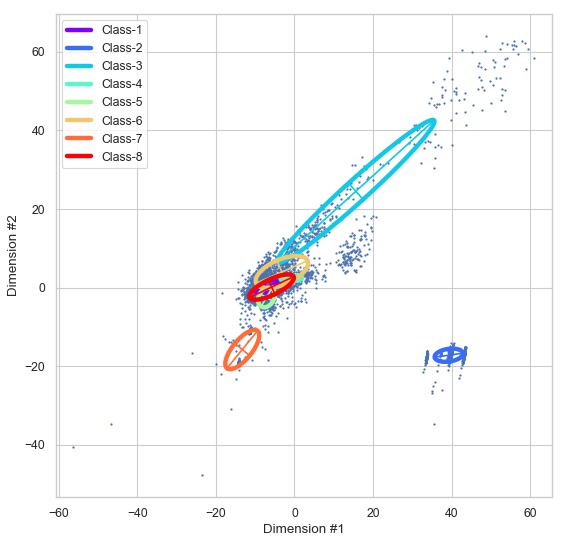

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(Xr[:,id[0]],Xr[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
colors = mpl.colors.cnames.items()
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
#    el,ax = plot_GMMellipse0(gmm,id,ik,colors[ik][0],ax,label="Class-%i"%(ik+1))
    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)
#    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),std=[1],linewidth=4)
ax.legend(loc='upper left')
plt.show()

In [79]:

def sns_GMMellipse(x,y,gmm=[],id=[],std=[1],main_axes=True,label="?",**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    K = gmm.n_components
#    colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
    colors = sns.color_palette("Paired", K)
    for ik in np.arange(K):
#        col = next(colors)
        col = colors[ik]
        covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
        d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
        d = np.diag(d)
        theta = np.arange(0,2*np.pi,0.02)
        x = np.sqrt(d[0,0])*np.cos(theta)
        y = np.sqrt(d[1,1])*np.sin(theta)
        xy = np.array((x,y)).T
        ii = 0
        for nstd in np.array(std):
            ii+=1
            ellipse = np.inner(v,xy).T
            ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
            if ii == 1:
                plt.plot(ellipse[:,0], ellipse[:,1], color=col, label=("%s")%(label),**kwargs)
            else:
                plt.plot(ellipse[:,0], ellipse[:,1], color=col, **kwargs)
        if main_axes: # Add Main axes:
            for idir in range(2):
                l = np.sqrt(d[idir,idir])*v[:,idir].T
                start = gmm.means_[ik,(id[0],id[1])]-l
                endpt = gmm.means_[ik,(id[0],id[1])]+l
                linex = [start[0], endpt[0]]
                liney = [start[1], endpt[1]]
                plt.plot(linex,liney,color=col)

C:\Users\ramya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


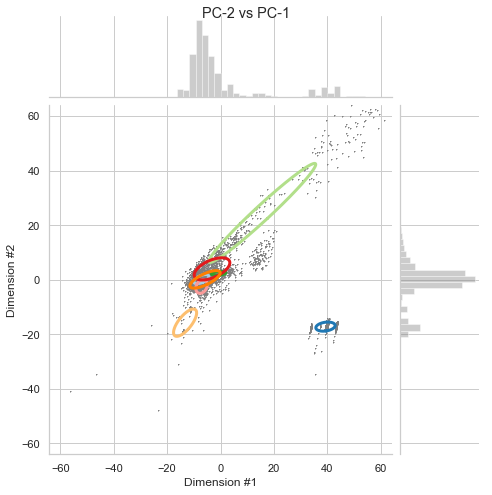

In [80]:
df = pd.DataFrame(Xr[:,id], columns=["x", "y"])
sns.set(context="notebook",style="whitegrid", color_codes=True)
g = sns.JointGrid(x="x", y="y", data=df, size=7, ratio=4, space=0.1,
                  xlim=vrangec(Xr[:,id]),ylim=vrangec(Xr[:,id]))

g.plot_marginals(sns.distplot, kde=False, color=".5")

g.plot_joint(plt.scatter, c=".5", s=1, linewidth=1, marker="+")

g.plot_joint(sns_GMMellipse, gmm=gmm, id=id, main_axes=False, linewidth=3)

g.set_axis_labels("Dimension #%i"%(id[0]+1), "Dimension #%i"%(id[1]+1))
g.fig.suptitle("PC-%i vs PC-%i"%(id[1]+1,id[0]+1))
plt.show()

C:\Users\ramya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\ramya\Anaconda3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'kind'
  s)


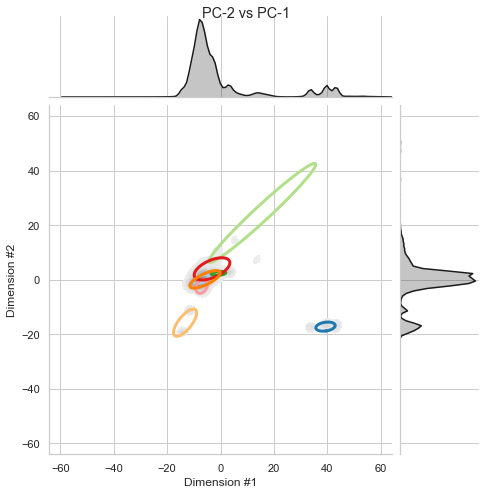

C:\Users\ramya\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\ramya\Anaconda3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'kind'
  s)


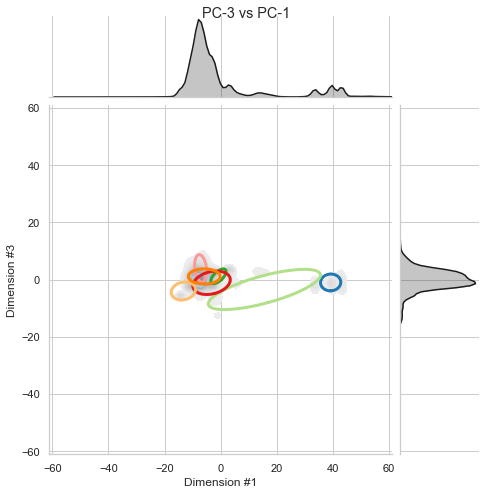

In [81]:
for ii in np.arange(2,4):
    id = np.array([1,ii])-1
    df = pd.DataFrame(Xr[:,id], columns=["x", "y"])
    sns.set(context="notebook",style="whitegrid", color_codes=True)
    g = sns.JointGrid(x="x", y="y", data=df, size=7, ratio=4, space=0.1,
                      xlim=vrangec(Xr[:,id]),ylim=vrangec(Xr[:,id]))
    #g.plot_joint(sns.kdeplot, cmap="Purples_d", kind='hex', linewidth=1, color='k', n_levels=30)
    #g.plot_joint(sns.kdeplot, shade = True, cmap="Purples_d", kind='hex', n_levels=30)
    g.plot_joint(sns.kdeplot, shade = True, \
                 shade_lowest=False,\
                 cmap=sns.light_palette("gray",reverse=False,as_cmap=True), kind='hex', n_levels=30)
    #g.plot_joint(sns.kdeplot, shade = False, kind='hex', n_levels=10)
    g.plot_marginals(sns.kdeplot, color="k", shade=True)

    g.plot_joint(sns_GMMellipse, gmm=gmm, id=id, main_axes=False, linewidth=3)

    g.set_axis_labels("Dimension #%i"%(id[0]+1), "Dimension #%i"%(id[1]+1))
    g.fig.suptitle("PC-%i vs PC-%i"%(id[1]+1,id[0]+1))
    plt.show()

Number of raw features (Depth Levels):  401
Number of samples (N profiles):  7397
(7397, 401)
7397 7397


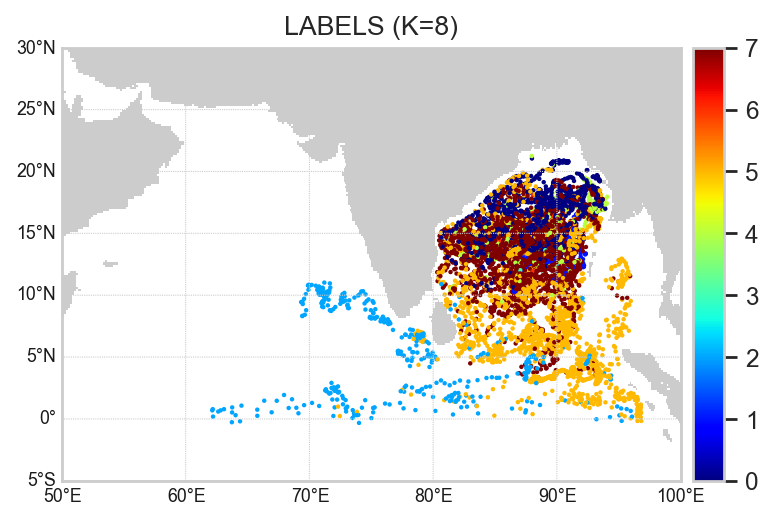

7397


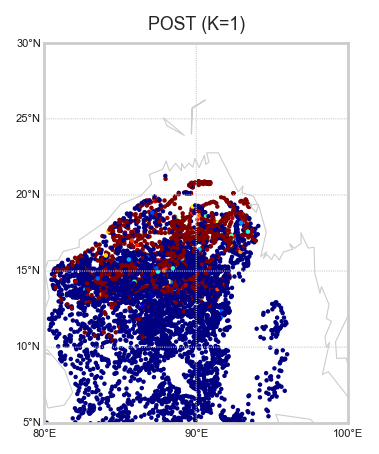

7397


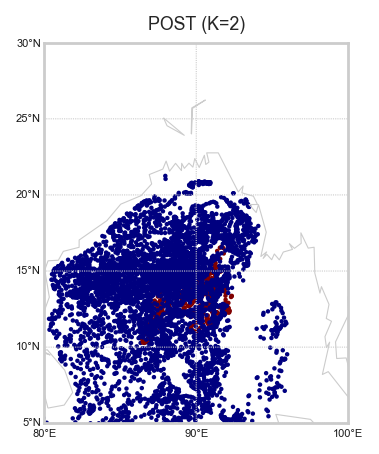

7397


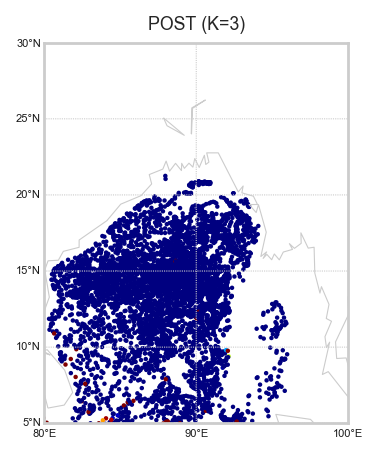

7397


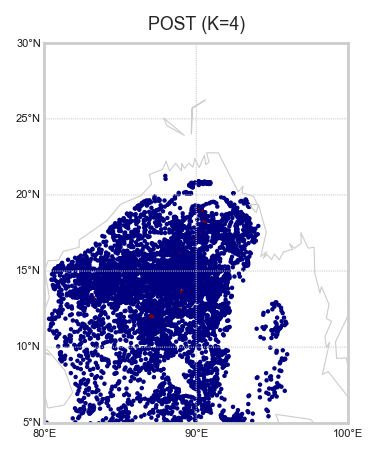

7397


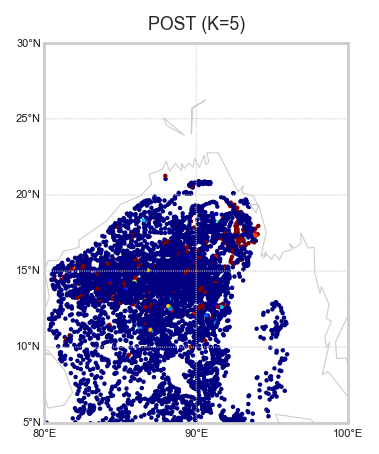

7397


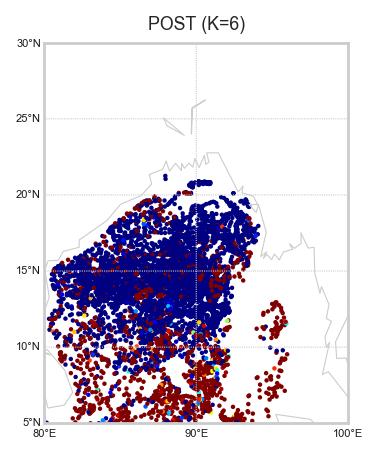

7397


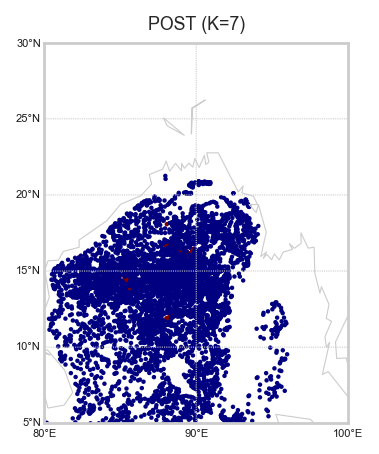

7397


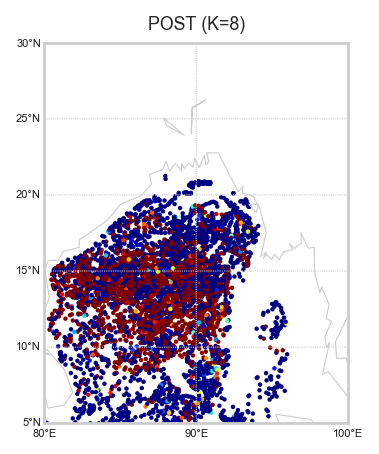

Wall time: 7.5 s


In [82]:
%%time
os.chdir('C:\\Users\\ramya\\Desktop\\myftpserver\\New Folder')
l=os.listdir()
leng=len(l)
latfs=[]
longfs=[]
for i in range(1,leng):  
    dsets=xarray.open_mfdataset(l[i])
    latfs= np.append(latfs,dsets['LATITUDE'].values)
    longfs=np.append(longfs,dsets['LONGITUDE'].values)

DPTmodel=np.linspace(0,2000,401)
size=[len(longfs),DPTmodel.shape[0]]
Xtest=np.ndarray(size,'float32')
sal_ftest=np.ndarray(size,'float32')
j=0
for i in range(1,leng):  
    dsets=xarray.open_mfdataset(l[i])
    tempf = dsets['TEMP_ADJUSTED'].values 
    pf=dsets['PRES_ADJUSTED'].values
    longf = dsets['LONGITUDE'].values
    latf = dsets['LATITUDE'].values
    sf=dsets['PSAL_ADJUSTED'].values
    [a,b]=pf.shape
    g=pf.shape
    dpf=np.ndarray(g,'float32')
    for ii in range(a):
        dpf[ii]=np.asarray((sw.dpth(pf[ii],latf[ii])))
    sh=[a,DPTmodel.shape[0]]
    salinef=np.ndarray(sh,'float32') 
    #interpolation
    for i3 in range(a):
        #tempf2[i3]=np.interp(DPTmodel,dpf[i3],tempf[i3])
        salinef[i3]=np.interp(DPTmodel,dpf[i3],sf[i3])

        
    for i4 in range(a):
        sal_ftest[j]=salinef[i4]
        j+=1
    
df=pd.DataFrame(sal_ftest)
df=df.ffill(axis=0).values
sal_ftest=df
df=pd.DataFrame(sal_ftest)
df=df.bfill(axis=0).values
sal_ftest=df

Xtest=Xtest[~np.isnan(Xtest).any(axis=1)]        
DPTmodel*=-1
[Np, Nz] = sal_ftest.shape
print("Number of raw features (Depth Levels): ", Nz )
print("Number of samples (N profiles): ", Np)
# Normalize data:
Xn = scaler.transform(sal_ftest)  
print(sal_ftest.shape)

# Reduce the dataset (compute the y):
Xr = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

# Classify the dataset:
LABELS = gmm.predict(Xr) # [Np,1]
POST   = gmm.predict_proba(Xr) # [Np,Nc]
print(len(LABELS),len(POST))

mp0 = bm(projection='cyl',\
        llcrnrlat=-5,urcrnrlat=30,\
        llcrnrlon=50,urcrnrlon=100,\
        lat_ts=0,resolution='c')
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5), dpi=160, facecolor='w', edgecolor='k') 
axes = np.reshape(axes,(1,1))
for ie in range(1):
    mp = mp0
    mp.ax = axes[0,ie]
    plt.jet()
    sc = mp.scatter(longfs,latfs,1,LABELS)
    mp.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1], color='0.8', linewidth=0.5, fontsize=8)
    mp.drawparallels(np.arange(-80, 80, 5), labels=[1,0,0,0], color='0.8', linewidth=0.5, fontsize=8)
    mp.drawlsmask(land_color='0.8', ocean_color='w')
#    mp.drawcoastlines()
    mp.colorbar(sc,ax=axes[0,ie])
#    ax.set_title(tit)
    axes[0,ie].set_title("LABELS (K=%i)"%(K))
plt.tight_layout()
plt.show()

mp0 = bm(projection='cyl',\
        llcrnrlat=5,urcrnrlat=30,\
        llcrnrlon=80,urcrnrlon=100,\
        lat_ts=0,resolution='c')
#print(len(lat),len(long))
for ie in range(K):
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,3), dpi=160, facecolor='w', edgecolor='k') 
    mp = mp0
    mp.ax = ax
    mp.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1], color='0.8', linewidth=0.5, fontsize=5)
    mp.drawparallels(np.arange(-80, 80, 5), labels=[1,0,0,0], color='0.8', linewidth=0.5, fontsize=5)
#    mp.drawlsmask(ax=ax,land_color='0.8', ocean_color='w')
    mp.drawcoastlines(ax=ax, linestyle='solid', color='0.8', linewidth=0.5)
    print(len(POST[:,ie]))
    sc = mp.scatter(longfs,latfs,1,POST[:,ie])
#    mp.colorbar(sc,ax=axes[0,ie])
    ax.set_title("POST (K=%i)"%(ie+1),fontsize=8)
    plt.tight_layout()
    plt.show()

